In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import regionmask # need to install this (dependent on geopandas) using pip, AFTER everything else!
import xesmf as xe
from scipy import stats

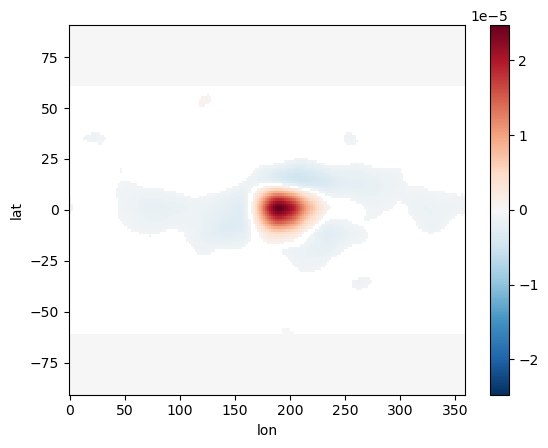

In [28]:
HK_gto = xr.open_dataarray("GTO_data/GTO_lat00_lon1875.nc")
HK_gto.plot()

# Set regions with zeros to `nan` and mask out land points

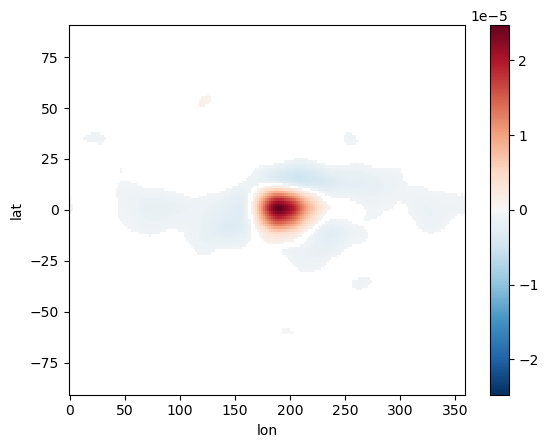

In [29]:
HK_gto_maskZero = HK_gto.where(abs(HK_gto)>0)
HK_gto_maskZero.plot()

In [30]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(HK_gto.lon.values, HK_gto.lat.values)

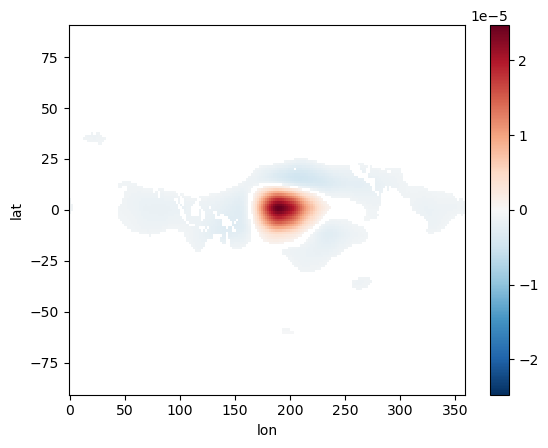

In [31]:
HK_gto_maskZeroAndLand = HK_gto_maskZero.where(np.isnan(land), np.nan)
HK_gto_maskZeroAndLand.plot()

# Next step, multiply with observed SSTs and take global mean to reconstruct

In [32]:
hadsst = xr.open_dataset("/gws/nopw/j04/aopp/andreww/CPDN/data/HadISST_sst.nc")['sst'].rename({'latitude':'lat', 'longitude':'lon'})
hadsst

<xarray.DataArray 'sst' (time: 1786, lat: 180, lon: 360)>
[115732800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2018-10-...
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

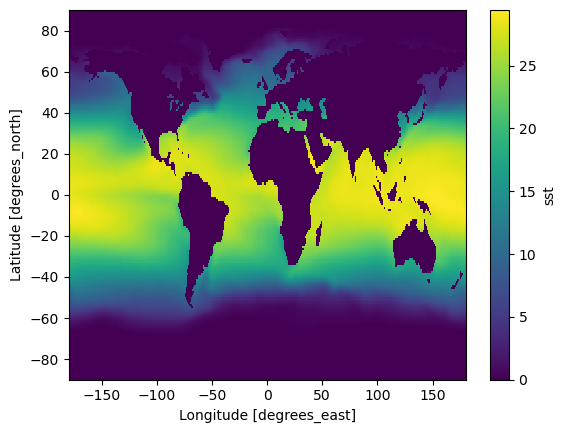

In [33]:
hadsst_zero = hadsst.where(hadsst>0,0)
hadsst_zero.mean('time').plot()

In [34]:
""" Take an annual mean """
hadsst_annual_mean = hadsst_zero.resample(time='1Y').mean('time')
hadsst_annual_mean

<xarray.DataArray 'sst' (time: 149, lat: 180, lon: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1870-12-31 1871-12-31 ... 2018-12-31
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

## Note! The observed SST data is on a different lat-lon grid, so we need to regrid the GTO 

In [35]:
"""Regridding function"""

ds_target = xr.Dataset({'lat': (['lat'], hadsst_annual_mean.lat.data),
                        'lon': (['lon'], hadsst_annual_mean.lon.data),})

def regrid_to_target(ds, ds_target=ds_target, method='bilinear', save_weights=False):
    """
    Regrid from rectilinear grid to common grid
    
    Bilinear and conservative should be the most commonly used methods. 
    They are both monotonic (i.e. will not create new maximum/minimum). 
    """
    regridder = xe.Regridder(ds, ds_target, method, periodic=True, reuse_weights=save_weights)
    return regridder(ds)

In [36]:
"""
Before using the regridder, we need to shift the GTO longitudes from 0->360 to -180->180
and add some metadata to the GTO DataArray.

Don't ask why, it's just a tedious thing we must do...
"""

HK_gto_maskZeroAndLand_fixedLon = HK_gto_maskZeroAndLand.assign_coords(lon=(((HK_gto_maskZeroAndLand.lon - 180) % 360) - 180)).sortby('lon')

HK_gto_maskZeroAndLand_fixedLon['lat'].attrs=hadsst_annual_mean['lat'].attrs
HK_gto_maskZeroAndLand_fixedLon['lon'].attrs=hadsst_annual_mean['lon'].attrs

HK_gto_maskZeroAndLand_fixedLon

<xarray.DataArray (lat: 145, lon: 192)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon      (lon) float32 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1

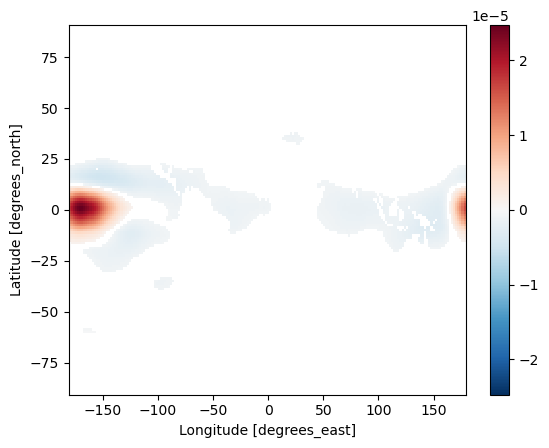

In [37]:
HK_gto_maskZeroAndLand_fixedLon.plot()

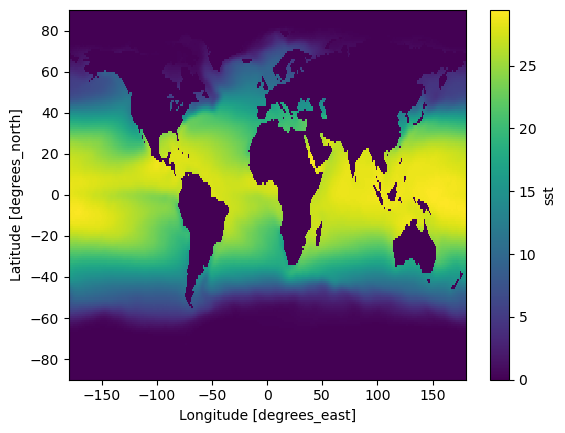

In [38]:
hadsst_annual_mean.mean('time').plot()

In [39]:
%%time
""" Regrid"""
HK_GTO_SSTgrid = regrid_to_target(ds=HK_gto_maskZeroAndLand_fixedLon)

/home/users/jwang28/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 1.18 s, sys: 45.6 ms, total: 1.22 s
Wall time: 1.25 s


/home/users/jwang28/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


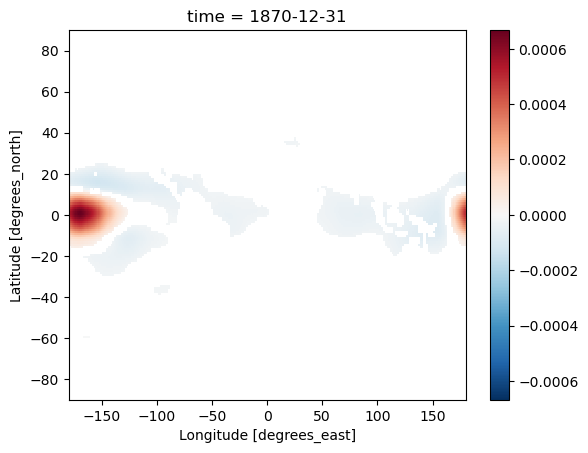

In [40]:
(hadsst_annual_mean[0,...]*HK_GTO_SSTgrid).plot()

# Do the reconstruction

This is how Hugh Baker does it (for more details you can see the python script he sent me at: `/gws/nopw/j04/aopp/andreww/CPDN/rpm_formatt.py`).

Note also that you can basically set `gamma` in Eq4 of Baker et al (2019) equal to anything, it doesn't matter! (Because you'll eventually rescale the whole thing anyways)

```
    # Note that because we (and Hugh) regridded the GTO to the 1x1deg lat-lon grid of the observed SSTs, the latitude/longitude spacings are = 1 deg
    meshlat = np.zeros([180, 360])
    meshlat[:, :] = np.expand_dims(lat_sst, axis=1)
    meshlatweight = np.cos(meshlat * np.pi/180) * 6371**2 * 1 * 1 * (np.pi/180)**2

    jet_recon_monthly = np.zeros((2, 2, months*147))
    jet_recon = np.zeros((2, 2, 147))

    sst_s = sst_0[sindices]
    sst_s = sst_s * meshlatweight
    for y in range(147*months):
        jet_recon_monthly[0, b, y] = np.nansum(sst_s[y]*gto_interp[0, b])/20  # 2gamma
```

The code is quite ugly (we can do better using `da.weighted()`) but it's a good sanity check at least.

In [41]:
weights      = np.cos(np.deg2rad(HK_GTO_SSTgrid.lat))* 6371**2 * 1 * 1 * (np.pi/180)**2 * HK_GTO_SSTgrid
#weights = np.cos(np.deg2rad(HK_GTO_SSTgrid.lat)) * HK_GTO_SSTgrid
product  = hadsst_annual_mean.weighted(weights.fillna(0))
prediction = product.sum(('lon', 'lat'), skipna=True)

# Now, compare with ERA-20C

In [5]:
#pr_era20c = xr.open_dataset("/gws/nopw/j04/aopp/strat_clim_data/reanalysis/era20c/Precip1900-2010.nc")['tp']
#pr_era20c_annualMean = pr_era20c.rename({'latitude':'lat', 'longitude':'lon'}).resample(time='1Y').mean('time').compute()
pr_era20c_annualMean = xr.open_dataarray("observed_mean_annual.nc")

In [7]:
pr_era20c_annualMean.sel(lat=-85.0, lon=5.0)

<xarray.DataArray (time: 111)>
[111 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1900-12-31 1901-12-31 ... 2010-12-31
    lat      float64 -85.0
    lon      float64 5.0
Attributes:
    regrid_method:  bilinear

#### I think you chose lat=22.5 and lon=114.375 for Hong Kong, so I'll extract the "observed" precip nearest to that grid point

In [45]:
HK_observedPrecip=pr_era20c_annualMean.sel(lat=0, lon=187.5, method='nearest')

# Now, compare!

The magnitudes are completely different, so to plot them on the same graph you'd need to rescale the prediction, but still, we can see the GTO approach has *SOME* skill, even when just reconstructing a single gridpoint (which we expect to be quite a hard thing - averaging over big regions would help).

For example, the GTO prediction seems to capture the decline of annual mean HK precipitation from 1900->1950 ish, and then a recovery, but the magnitudes are not quite correct (probably also because other things contribute to precipitaiton other than just SSTs, and also we know the linear GTO assumptions are not perfect)

Put both on the same scale. To do this we need to perform a simple linear regression to work out the coefficients $\alpha$ and $\beta$ where

$$ \mathrm{Precip}_{scaled} = \alpha \mathrm{Precip}_{reconstructed} + \beta $$

In [46]:
alpha, beta, r, p, se = stats.linregress(prediction.sel(time=slice('1900', '2010')), HK_observedPrecip)
print(alpha, beta, r)

2.7349266380912366e-05 -0.0355855194283612 0.7953538737274647


In [47]:
prediction_scaled = alpha * prediction + beta

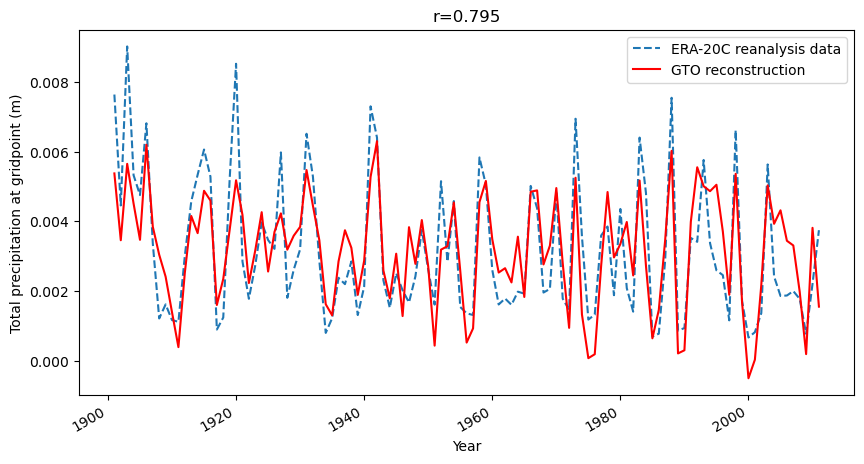

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplots_adjust(bottom=0.15)
HK_observedPrecip.plot(ax=ax, label='ERA-20C reanalysis data', linestyle='dashed')
prediction_scaled.sel(time=slice('1900', '2010')).plot(ax=ax, label='GTO reconstruction', color='red')
ax.set_ylabel('Total precipitation at grid point (m)')
ax.set_xlabel('Year')
ax.legend()
ax.set_title('r={}'.format(round(r,3)))
plt.savefig('HK_reconstruction.pdf')  